In [1]:
import numpy as np
import numpy.random as nr
import numpy.linalg as nl
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def fromfile_tril(*args, **kwargs):
    """Read a symmetric matrix stored as just the lower triangular part.

    For an MxM matrix, the lower triangular part takes up just N=M*(M+1)/2 bytes
    instead of M^2 bytes. This is simply a wrapper around numpy.fromfile that
    then converts the resulting array into an M*M matrix.
    """
    X = np.fromfile(*args, **kwargs)

    N = len(X)
    M = (np.sqrt(1+8*N)-1)/2
    if int(M) != M:
        raise ValueError('Length of matrix not of form M*(M+1)/2')
    M = int(M)

    Y = np.empty((M,M), X.dtype)
    indices = np.tril_indices(M)

    # set the lower triangular part and the transpose to X
    Y[indices] = Y[indices[::-1]] = X

    return(Y)

In [4]:
def tau(Ss):
    return(
        np.sum(Ss[0]*Ss[1]) /
        np.sqrt(
            np.sum(Ss[0]*Ss[0]) *
            np.sum(Ss[1]*Ss[1])
        )
    )

In [5]:
pops = ['eas', 'eur']
files = ['../common/ld/22.{}.ld.bin'.format(pop) for pop in pops]
Sigmas = [fromfile_tril(file) for file in files]
Sigmas = np.array(Sigmas)

In [6]:
frq = pd.read_table('../common/bfile.chr/22.frq.strat', delim_whitespace=True)
mafs = [ frq.query('CLST == "{}"'.format(pop)).MAF.values for pop in pops ]
sds = [ np.sqrt(2*maf*(1-maf)) for maf in mafs ]

In [7]:
M = Sigmas.shape[1]
Mt = 1000

In [8]:
lambdas = [0, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5]
typeds = [ nr.choice(M, Mt, replace=False) for i in range(100) ]

In [9]:
ratios_Sigma = list()
ratios_S = list()
for l in lambdas:
    lI = l*np.identity(M)
    Sigmas_prime = np.array([(Sigma + lI)/(1+l) for Sigma in Sigmas])
    ratios_Sigma.append([
        tau(Sigmas_prime[:,typed]) /
        tau(Sigmas_prime[:,typed[:,None],typed])
        for typed in typeds
    ])
    Ss_prime = np.array([ sd[:,None] * Sigma * sd[None,:] for Sigma, sd in zip(Sigmas_prime, sds)])
    ratios_S.append([
        tau(Ss_prime[:,typed]) /
        tau(Ss_prime[:,typed[:,None],typed])
        for typed in typeds
    ])

In [10]:
df_Sigma = pd.concat([
    pd.DataFrame(
        {
            'l':l,
            'i':range(100),
            'ratio':ratio
        }
    ) for l, ratio in zip(lambdas, ratios_Sigma)
])

In [11]:
df_S = pd.concat([
    pd.DataFrame(
        {
            'l':l,
            'i':range(100),
            'ratio':ratio
        }
    ) for l, ratio in zip(lambdas, ratios_S)
])

In [12]:
df_Sigma['type']='Sigma'
df_S['type']='S'

In [13]:
df = pd.concat([df_Sigma, df_S])

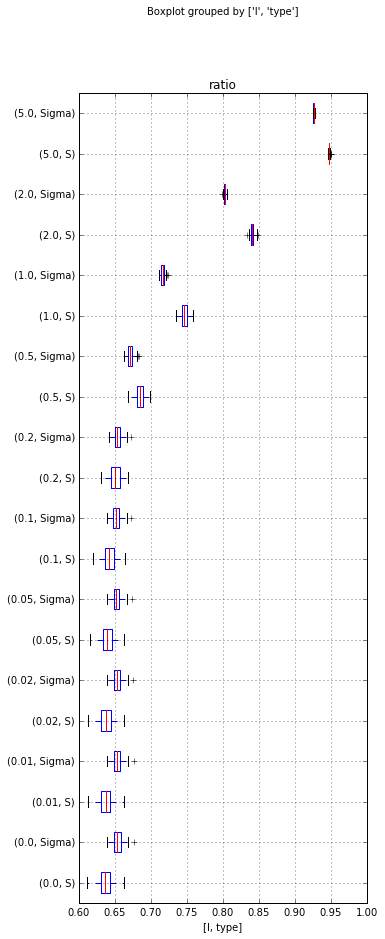

In [14]:
df.boxplot('ratio', ['l', 'type'], figsize=(5,15), vert=False)
plt.show()

In [16]:
df.groupby(['type', 'l']).ratio.mean()

type   l   
S      0.00    0.637371
       0.01    0.637746
       0.02    0.638160
       0.05    0.639620
       0.10    0.642713
       0.20    0.650888
       0.50    0.684481
       1.00    0.746409
       2.00    0.840785
       5.00    0.947543
Sigma  0.00    0.653835
       0.01    0.653491
       0.02    0.653189
       0.05    0.652526
       0.10    0.652164
       0.20    0.653792
       0.50    0.671025
       1.00    0.716270
       2.00    0.802786
       5.00    0.926308
Name: ratio, dtype: float64